In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F


In [2]:
# ----------------------------
# Denoising AutoEncoder model
# ----------------------------
class DenoisingAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, noise_level=0.05):  # CHANGED: default noise_level from 0.3 to 0.05
        super().__init__()
        self.noise_level = noise_level
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, training=False):
        if training:
            noise = torch.bernoulli((1 - self.noise_level) * torch.ones_like(x))
            x = x * noise
        return self.decoder(self.encoder(x))

# ----------------------------
# Masked MSE Loss
# ----------------------------
def masked_mse_loss(original, reconstructed, mask):
    diff = (original - reconstructed) ** 2
    masked_diff = diff * mask
    return masked_diff.sum() / mask.sum()

# ----------------------------
# Training the DAE (with val + early stopping)
# ----------------------------
def train_dae(X_np, mask_np, epochs=100, lr=1e-3, hidden_dim=64, noise_level=0.2, patience=10):  # CHANGED: default noise_level
    input_dim = X_np.shape[1]
    model = DenoisingAutoEncoder(input_dim, hidden_dim, noise_level)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Convert to tensors
    original = torch.tensor(X_np, dtype=torch.float32)
    mask = torch.tensor(mask_np, dtype=torch.float32)
    #inputs = torch.nan_to_num(original, nan=0.0)
    col_mean = np.nanmean(X_np, axis=0)
    inputs_np = np.where(np.isnan(X_np), col_mean, X_np)
    inputs = torch.tensor(inputs_np, dtype=torch.float32)


    # Split into train/val (90-10 split)  # ADDED
    n = inputs.shape[0]
    idx = int(n * 0.9)
    train_inp, val_inp = inputs[:idx], inputs[idx:]
    train_ori, val_ori = original[:idx], original[idx:]
    train_mask, val_mask = mask[:idx], mask[idx:]

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_inp, training=True)
        loss = masked_mse_loss(train_ori, output, train_mask)
        loss.backward()
        optimizer.step()

        # Validation pass  # ADDED
        model.eval()
        with torch.no_grad():
            val_output = model(val_inp, training=False)
            val_loss = masked_mse_loss(val_ori, val_output, val_mask)

        # Early stopping  # ADDED
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1} — val loss: {val_loss.item():.4f}")
                break

    # Load best model
    model.load_state_dict(best_model)
    return model

# ----------------------------
# Impute numerical using DAE
# ----------------------------
def impute_with_dae(model, X_np, mask_np):
    model.eval()
    with torch.no_grad():
        inputs = torch.nan_to_num(torch.tensor(X_np, dtype=torch.float32), nan=0.0)
        recon = model(inputs, training=False).numpy()
    X_imputed = X_np.copy()
    X_imputed[mask_np] = recon[mask_np]
    return X_imputed

# ----------------------------
# Full pipeline: DAE + Mode
# ----------------------------
def impute_dataframe_with_dae_and_mode(df, num_cols, cat_cols,
                                       epochs=100, lr=1e-3, hidden_dim=64, noise_level=0.05):  # CHANGED default noise_level
    df = df.copy()

    # Step 1: Handle categorical columns — fill with "Missing" temporarily for DAE
    df[cat_cols] = df[cat_cols].fillna("Missing")

    # Step 2: Handle numerical columns — prepare for DAE
    df_num = df[num_cols]
    mask = df_num.isna().values
    # Compute mean and std only on observed entries
    observed = ~mask
    means = np.sum(df_num.fillna(0).values * observed, axis=0) / observed.sum(axis=0)
    stds = np.sqrt(np.sum(((df_num.fillna(0).values - means) * observed) ** 2, axis=0) / observed.sum(axis=0))
    
    # Avoid divide-by-zero
    stds[stds == 0] = 1.0
    
    # Standardize using only valid entries
    df_filled = df_num.fillna(dict(zip(df_num.columns, means)))

    X_scaled = (df_filled.values - means) / stds

    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(df_num.fillna(0))

    # Step 3: Train and impute with DAE
    dae_model = train_dae(X_scaled, mask, epochs=epochs, lr=lr,
                          hidden_dim=hidden_dim, noise_level=noise_level)  # CHANGED
    #X_imputed = impute_with_dae(dae_model, X_scaled, mask)
    X_imputed_scaled = impute_with_dae(dae_model, X_scaled, mask)

    X_imputed = X_imputed_scaled * stds + means
    #X_imputed = scaler.inverse_transform(X_imputed)

    # Step 4: Replace imputed values back
    df[num_cols] = X_imputed

    # Step 5: Impute categorical columns with most frequent (mode)
    cat_imputer = SimpleImputer(strategy="most_frequent")
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

    return df


In [16]:
def simulate_missingness(X, missing_rate=0.2, seed=42):
    np.random.seed(seed)
    X_missing = X.copy()
    mask = np.random.rand(*X.shape) < missing_rate
    X_missing[mask] = np.nan
    return X_missing
def drop_rate_experiment_with_test_missingness_and_dae(
    df, drop_rates=[1.0, 0.75, 0.5, 0.25, 0.1],
    missing_rate=0.2, seed=42,
    dae_params={"epochs": 100, "lr": 1e-3, "hidden_dim": 64, "noise_level": 0.2}
):
    results = []

    np.random.seed(seed)

    # Separate numeric and categorical columns
    target_cols = ['OS', 'OS.time']
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns if col not in target_cols]
    print(numeric_cols)
    cat_cols = df.select_dtypes(exclude=[np.number]).columns
    print(cat_cols)
    df_clean = df[numeric_cols + cat_cols.tolist()].dropna()
    df_clean = df_clean.drop(columns=[col for col in target_cols if col in df_clean.columns])

    # Drop rows with missing values for clean baseline
    #df_clean = df[numeric_cols.tolist() + cat_cols.tolist()].dropna()

    # Encode categorical variables
    label_encoders = {}
    df_encoded = df_clean.copy()
    for col in cat_cols:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le

    # Train/test split
    X_full = df_encoded.copy()
    X_train_full, X_test_full = train_test_split(X_full, test_size=0.2, random_state=seed)

    for drop_rate in drop_rates:
        print(f"\n Drop Rate: {int(drop_rate * 100)}%")
        size = int(len(X_train_full) * drop_rate)
        X_train = X_train_full.iloc[:size].copy()
        X_test = X_test_full.copy()

        # Simulate missingness
        X_train_missing = simulate_missingness(X_train, missing_rate=missing_rate, seed=seed)
        X_test_missing = simulate_missingness(X_test, missing_rate=missing_rate, seed=seed + 1)

        # Ground truths
        X_test_gt = X_test[numeric_cols]

        # Split numeric/categorical
        train_num = X_train_missing[numeric_cols]
        test_num = X_test_missing[numeric_cols]

        train_cat = X_train_missing[cat_cols]
        test_cat = X_test_missing[cat_cols]
        test_cat_gt = X_test[cat_cols]

        # Normalize (from non-missing training ground truth)
        mean = train_num.mean()
        std = train_num.std()
        mean_arr = mean.values
        std_arr = std.values
        std_arr[std_arr == 0] = 1.0

        X_test_gt_norm = (X_test_gt.values - mean_arr) / std_arr

        # --------------------------
        # Mean Imputation
        # --------------------------
        mean_imputer = SimpleImputer(strategy='mean')
        mean_imputer.fit(train_num)
        test_mean = mean_imputer.transform(test_num)
        test_mean_norm = (test_mean - mean_arr) / std_arr
        rmse_mean = np.sqrt(mean_squared_error(X_test_gt_norm, test_mean_norm))
        mae_mean = mean_absolute_error(X_test_gt_norm, test_mean_norm)

        # --------------------------
        # kNN Imputation
        # --------------------------
        knn_imputer = KNNImputer(n_neighbors=5)
        knn_imputer.fit(train_num)
        test_knn = knn_imputer.transform(test_num)
        test_knn_norm = (test_knn - mean_arr) / std_arr
        rmse_knn = np.sqrt(mean_squared_error(X_test_gt_norm, test_knn_norm))
        mae_knn = mean_absolute_error(X_test_gt_norm, test_knn_norm)

        # --------------------------
        # MICE Imputation
        # --------------------------
        mice_imputer = IterativeImputer(random_state=42, max_iter=10)
        mice_imputer.fit(train_num)
        test_mice = mice_imputer.transform(test_num)
        test_mice_norm = (test_mice - mean_arr) / std_arr
        rmse_mice = np.sqrt(mean_squared_error(X_test_gt_norm, test_mice_norm))
        mae_mice = mean_absolute_error(X_test_gt_norm, test_mice_norm)

        # --------------------------
        # DAE Imputation
        # --------------------------
        # Fill missing with mean for scaling
        mask_train = train_num.isna().values
        observed_train = ~mask_train
        means = np.sum(train_num.fillna(0).values * observed_train, axis=0) / observed_train.sum(axis=0)
        stds = np.sqrt(np.sum(((train_num.fillna(0).values - means) * observed_train) ** 2, axis=0) / observed_train.sum(axis=0))
        stds[stds == 0] = 1.0

        df_filled = train_num.fillna(dict(zip(train_num.columns, means)))
        X_scaled = (df_filled.values - means) / stds

        dae_model = train_dae(X_scaled, mask_train, **dae_params)

        # Impute test data using DAE
        mask_test = test_num.isna().values
        X_test_filled = test_num.fillna(dict(zip(test_num.columns, means)))
        X_test_scaled = (X_test_filled.values - means) / stds
        X_test_imputed_scaled = impute_with_dae(dae_model, X_test_scaled, mask_test)
        X_test_dae = X_test_imputed_scaled * stds + means
        X_test_dae_norm = (X_test_dae - mean_arr) / std_arr
        rmse_dae = np.sqrt(mean_squared_error(X_test_gt_norm, X_test_dae_norm))
        mae_dae = mean_absolute_error(X_test_gt_norm, X_test_dae_norm)

        # --------------------------
        # Categorical Imputation
        # --------------------------
        cat_imputer = SimpleImputer(strategy="most_frequent")
        cat_imputer.fit(train_cat)
        test_cat_imputed = cat_imputer.transform(test_cat)
        cat_accuracy = (test_cat_gt.values == test_cat_imputed).mean()

        # --------------------------
        # Store results
        # --------------------------
        results.append({
            'Drop Rate': drop_rate,
            'RMSE_Mean': rmse_mean,
            'MAE_Mean': mae_mean,
            'RMSE_kNN': rmse_knn,
            'MAE_kNN': mae_knn,
            'RMSE_MICE': rmse_mice,
            'MAE_MICE': mae_mice,
            'RMSE_DAE': rmse_dae,
            'MAE_DAE': mae_dae,
            'Cat_Accuracy': cat_accuracy
        })

    return pd.DataFrame(results)


In [17]:
def plot_results(results_df):
    plt.figure(figsize=(18, 5))

    # RMSE
    plt.subplot(1, 3, 1)
    plt.plot(results_df['Drop Rate'], results_df['RMSE_DAE'], label='DAE', marker='o')
    plt.plot(results_df['Drop Rate'], results_df['RMSE_Mean'], label='Mean', marker='s')
    plt.plot(results_df['Drop Rate'], results_df['RMSE_kNN'], label='kNN', marker='^')
    plt.plot(results_df['Drop Rate'], results_df['RMSE_MICE'], label='MICE', marker='v')
    plt.title("RMSE vs Drop Rate")
    plt.xlabel("Drop Rate")
    plt.ylabel("Normalized RMSE")
    plt.legend()
    plt.grid(True)

    # MAE
    plt.subplot(1, 3, 2)
    plt.plot(results_df['Drop Rate'], results_df['MAE_DAE'], label='DAE', marker='o')
    plt.plot(results_df['Drop Rate'], results_df['MAE_Mean'], label='Mean', marker='s')
    plt.plot(results_df['Drop Rate'], results_df['MAE_kNN'], label='kNN', marker='^')
    plt.plot(results_df['Drop Rate'], results_df['MAE_MICE'], label='MICE', marker='v')
    plt.title("MAE vs Drop Rate")
    plt.xlabel("Drop Rate")
    plt.ylabel("Normalized MAE")
    plt.legend()
    plt.grid(True)

    # Categorical Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(results_df['Drop Rate'], results_df['Cat_Accuracy'], label='Mode Imputation', marker='d', color='tab:purple')
    plt.title("Categorical Accuracy vs Drop Rate")
    plt.xlabel("Drop Rate")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


['Age at Diagnosis', 'Cohort', 'Lymph nodes examined positive', 'Mutation Count', 'Nottingham prognostic index', 'Relapse Free Status (days)', 'TMB (nonsynonymous)', 'Tumor Size', 'Tumor Stage']
Index(['Type of Breast Surgery', 'Cancer Type Detailed', 'Cellularity',
       'Chemotherapy', 'Pam50 + Claudin-low subtype',
       'ER status measured by IHC', 'ER Status', 'Neoplasm Histologic Grade',
       'HER2 status measured by SNP6', 'HER2 Status',
       'Tumor Other Histologic Subtype', 'Hormone Therapy',
       'Inferred Menopausal State', 'Integrative Cluster',
       'Primary Tumor Laterality', 'Oncotree Code', 'PR Status',
       'Radio Therapy', 'Relapse Free Status', '3-Gene classifier subtype'],
      dtype='object')

 Drop Rate: 100%
Early stopping at epoch 20 — val loss: 0.0004

 Drop Rate: 75%

 Drop Rate: 50%

 Drop Rate: 25%

 Drop Rate: 10%
Early stopping at epoch 61 — val loss: 0.0001


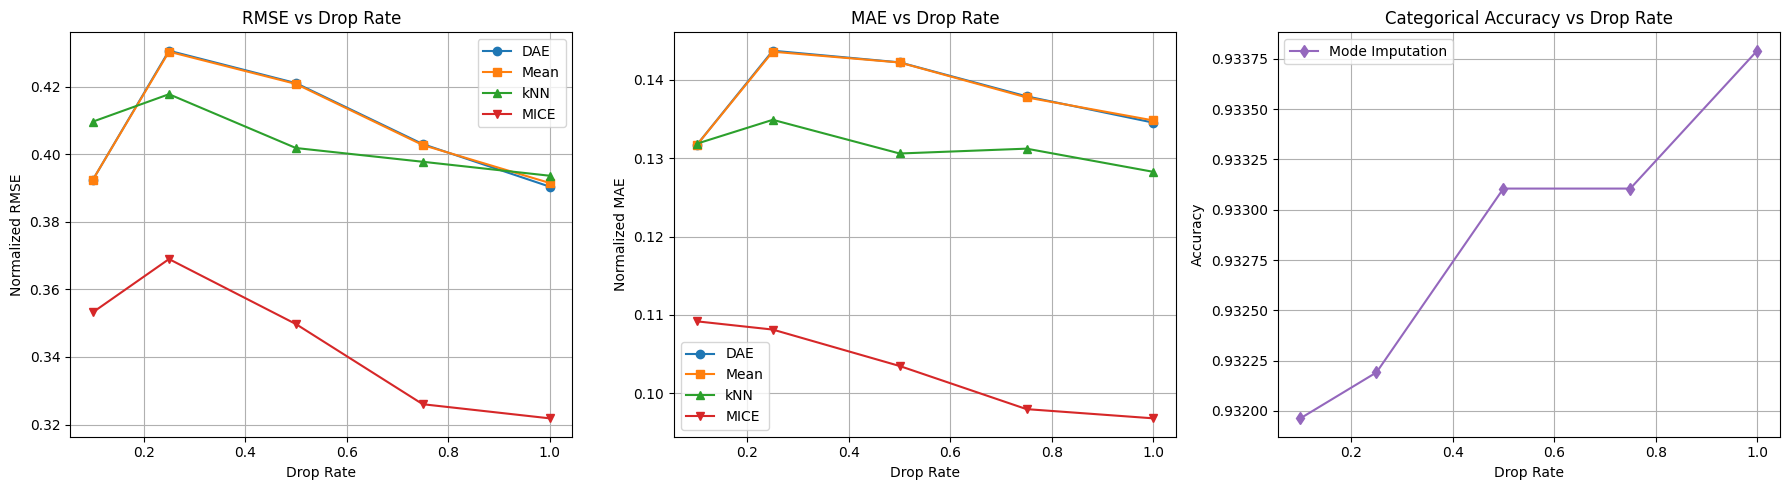

,Drop Rate,RMSE_Mean,MAE_Mean,RMSE_kNN,MAE_kNN,RMSE_MICE,MAE_MICE,RMSE_DAE,MAE_DAE,Cat_Accuracy
0,1.00,0.391523,0.134829,0.393668,0.128263,0.321827,0.096771,0.390440,0.134548,0.933790
1,0.75,0.402754,0.137776,0.397801,0.131226,0.326009,0.097949,0.403035,0.137911,0.933105
2,0.50,0.420860,0.142235,0.401876,0.130608,0.349750,0.103459,0.421095,0.142252,0.933105
3,0.25,0.430400,0.143614,0.417809,0.134912,0.368992,0.108112,0.430688,0.143739,0.932192
4,0.10,0.392490,0.131661,0.409686,0.131852,0.353230,0.109169,0.392467,0.131667,0.931963


In [19]:
df = pd.read_csv("/Users/simrantanwar/Desktop/College/DDP_phase2/New Experiments/data/metabric_before_imp.csv")
df = df.drop(['Unnamed: 0'],axis=1)
results_df = drop_rate_experiment_with_test_missingness_and_dae(df)
plot_results(results_df)
display(results_df)